# 🔒 PGD Adversarial Attack on MNIST Model
This notebook demonstrates how to test a simple MNIST model against Projected Gradient Descent (PGD) attacks using `cleverhans`.

In [11]:
!pip install torch torchvision cleverhans matplotlib

In [12]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent

In [13]:
# Load MNIST test set
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [14]:
# Define a simple model architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.fc(x)

!wget https://github.com/tdvan1804/PracticeRepo/raw/main/simple_mnist_model.pth

# Load pre-trained model (replace with path if needed)
model = SimpleNN()
model.load_state_dict(torch.load("simple_mnist_model.pth", map_location=torch.device('cpu')))
model.eval()

--2025-04-24 07:25:26--  https://github.com/tdvan1804/PracticeRepo/raw/main/simple_mnist_model.pth
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tdvan1804/PracticeRepo/main/simple_mnist_model.pth [following]
--2025-04-24 07:25:26--  https://raw.githubusercontent.com/tdvan1804/PracticeRepo/main/simple_mnist_model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32531 (32K) [application/octet-stream]
Saving to: ‘simple_mnist_model.pth.1’

simple_mnist_model. 100%[===================>]  31.77K  --.-KB/s    in 0.01s   

2025-04-24 07:25:27 (3.16 MB/s) - ‘simple_mnist_model.pth.1’ saved [32531/3

SimpleNN(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

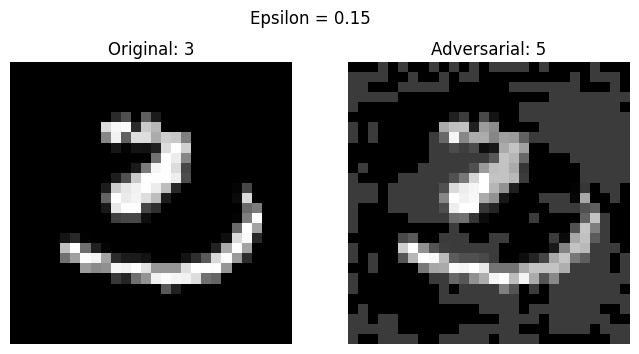

Epsilon: 0.15
✅ Accuracy on original images: 92.52%
⚠️ Accuracy after PGD attack: 4.22%


In [15]:
# Test PGD attack at different epsilon values
epsilon = 0.15
correct_original = 0
correct_adversarial = 0
total = 0
shown = False

for image, label in test_loader:
    image.requires_grad = True
    output_original = model(image)
    pred_original = output_original.argmax(dim=1)

    adv_image = projected_gradient_descent(model, image, eps=epsilon, eps_iter=0.01, nb_iter=40, norm=np.inf)
    output_adversarial = model(adv_image)
    pred_adversarial = output_adversarial.argmax(dim=1)

    correct_original += (pred_original == label).sum().item()
    correct_adversarial += (pred_adversarial == label).sum().item()
    total += label.size(0)

    if not shown:
        # Show original and adversarial image
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(image.squeeze().detach().numpy(), cmap='gray')
        axs[0].set_title(f"Original: {pred_original.item()}")
        axs[0].axis('off')

        axs[1].imshow(adv_image.squeeze().detach().numpy(), cmap='gray')
        axs[1].set_title(f"Adversarial: {pred_adversarial.item()}")
        axs[1].axis('off')

        plt.suptitle(f"Epsilon = {epsilon}")
        plt.show()
        shown = True

acc_original = 100 * correct_original / total
acc_adversarial = 100 * correct_adversarial / total

print(f"Epsilon: {epsilon}")
print(f"✅ Accuracy on original images: {acc_original:.2f}%")
print(f"⚠️ Accuracy after PGD attack: {acc_adversarial:.2f}%")